In [85]:
# Cell 1
import os
import numpy as np
from tqdm import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [86]:
# Cell 2
class OpenFWIDataset(Dataset):
    def __init__(self, data_dir, split="train"):
        assert split in ["train", "val"]
        self.waves = np.load(os.path.join(data_dir, f"{split}_waves.npy")).astype(np.float32)
        self.vels  = np.load(os.path.join(data_dir, f"{split}_vels.npy")).astype(np.float32)
        # 正規化
        self.waves /= 60.0
        self.vels  /= 4500.0

    def __len__(self):
        return len(self.waves)

    def __getitem__(self, idx):
        wave = torch.from_numpy(self.waves[idx])  # (C, T, W)
        vel  = torch.from_numpy(self.vels[idx])   # (1, H, W)
        return wave, vel


In [87]:
# Cell 3
data_dir = "../dataset_one_batch"
train_ds = OpenFWIDataset(data_dir, split="train")
val_ds   = OpenFWIDataset(data_dir, split="val")

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2)

# 動作確認
for xb, yb in train_loader:
    print(xb.shape, yb.shape)  # e.g. (8,5,1000,70), (8,1,70,70)
    break


torch.Size([8, 5, 1000, 70]) torch.Size([8, 1, 70, 70])


In [ ]:
# Cell 4

# --- スケジュール  ---
def linear_beta_schedule(T, beta_start=1e-4, beta_end=2e-2):
    return torch.linspace(beta_start, beta_end, T)

def get_alphas(betas):
    alphas = 1.0 - betas
    alpha_cum = torch.cumprod(alphas, dim=0)
    return alpha_cum.sqrt(), (1.0 - alpha_cum).sqrt()

# --- 時刻埋め込みユーティリティ ---
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__(); self.dim = dim
    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-torch.log(torch.tensor(10000.0)) * torch.arange(half, device=t.device) / (half - 1))
        args  = t[:, None].float() * freqs[None]
        return torch.cat([args.sin(), args.cos()], dim=-1)

# --- ResBlock + FiLM の UNet ---
class ResBlockFiLM(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, cond_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch,  out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, out_ch*2)
        self.cond_mlp = nn.Linear(cond_emb_dim, out_ch*2)
        self.nin = nn.Conv2d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()
    def forward(self, x, t_emb, c_emb):
        # 時刻FiLM
        gamma_t, beta_t = self.time_mlp(t_emb).chunk(2, dim=-1)
        # 条件FiLM
        gamma_c, beta_c = self.cond_mlp(c_emb).chunk(2, dim=-1)
        h = self.conv1(x)
        h = h * (1+gamma_t[:,:,None,None]) + beta_t[:,:,None,None]
        h = h * (1+gamma_c[:,:,None,None]) + beta_c[:,:,None,None]
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.nin(x)

class SimpleUNet(nn.Module):
    def __init__(self, cond_dim=128, time_emb_dim=128):
        super().__init__()
        self.time_emb = SinusoidalPosEmb(time_emb_dim)
        # cond_emb
        self.cond_proj = nn.Sequential(
            nn.Linear(5*1000*70, cond_dim),
            nn.SiLU(), nn.Linear(cond_dim, cond_dim)
        )
        # encoder
        self.rb1 = ResBlockFiLM(1,   64,  time_emb_dim, cond_dim)
        self.rb2 = ResBlockFiLM(64, 128,  time_emb_dim, cond_dim)
        # bottleneck
        self.rb3 = ResBlockFiLM(128,256,  time_emb_dim, cond_dim)
        # decoder
        self.rb4 = ResBlockFiLM(256,128,  time_emb_dim, cond_dim)
        self.rb5 = ResBlockFiLM(128,64,   time_emb_dim, cond_dim)
        self.out = nn.Conv2d(64,1,1)

    def forward(self, x, t, cond):
        B = x.size(0)
        t_emb    = self.time_emb(t)
        cond_emb = self.cond_proj(cond)
        h1 = self.rb1(x,   t_emb, cond_emb)
        h2 = F.avg_pool2d(h1,2); h2 = self.rb2(h2, t_emb, cond_emb)
        h3 = F.avg_pool2d(h2,2); h3 = self.rb3(h3, t_emb, cond_emb)
        u1 = F.interpolate(h3, size=h2.shape[2:], mode='bilinear', align_corners=False)
        u1 = self.rb4(u1+h2, t_emb, cond_emb)
        u2 = F.interpolate(u1, size=h1.shape[2:], mode='bilinear', align_corners=False)
        u2 = self.rb5(u2+h1, t_emb, cond_emb)
        return self.out(u2)


In [88]:
# Cell 5
def train_ddpm(data_dir, save_path="best_ddpm_model.pt",
               T=1000, epochs=100, batch_size=8, lr=1e-4,
               weight_decay=1e-4, patience=10):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    betas = linear_beta_schedule(T).to(device)
    sqrt_ac, sqrt_1mac = get_alphas(betas)

    train_ds = OpenFWIDataset(data_dir, "train")
    val_ds   = OpenFWIDataset(data_dir, "val")
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)

    model     = SimpleUNet().to(device)
    opt       = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    sch       = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", patience=5, factor=0.5)
    best_val  = float("inf"); no_imp = 0

    for ep in range(1, epochs+1):
        # train
        model.train(); run_tr = 0.0
        for wave, vel in train_dl:
            wave, vel = wave.to(device), vel.to(device)
            B = vel.size(0)
            t     = torch.randint(0, T, (B,), device=device)
            noise = torch.randn_like(vel)
            x_t   = sqrt_ac[t][:,None,None,None]*vel + sqrt_1mac[t][:,None,None,None]*noise
            cond  = wave.view(B,-1)
            eps_p = model(x_t, t, cond)
            loss  = F.mse_loss(eps_p, noise)
            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0); opt.step()
            run_tr += loss.item()*B
        tr_mse = run_tr/len(train_ds)

        # val
        model.eval(); run_val=0.0
        with torch.no_grad():
            for wave, vel in val_dl:
                wave, vel = wave.to(device), vel.to(device)
                B = vel.size(0)
                t     = torch.randint(0, T, (B,), device=device)
                noise = torch.randn_like(vel)
                x_t   = sqrt_ac[t][:,None,None,None]*vel + sqrt_1mac[t][:,None,None,None]*noise
                cond  = wave.view(B,-1)
                eps_p = model(x_t, t, cond)
                run_val += F.mse_loss(eps_p, noise, reduction="sum").item()
        val_mse = run_val/len(val_ds)
        sch.step(val_mse)

        flag = ""
        if val_mse < best_val:
            best_val = val_mse; torch.save(model.state_dict(), save_path)
            no_imp = 0; flag="  <-- best"
        else:
            no_imp +=1
        print(f"[{ep:03d}] Train MSE: {tr_mse:.4f}  Val MSE: {val_mse:.4f}{flag}")

        if no_imp>=patience:
            print(f"Early stop at epoch {ep} (no_imp={no_imp})")
            break

    print(f"Done! Best Val MSE: {best_val:.4f}")

# 実行
train_ddpm(data_dir)


[001] Train MSE: 0.1773  Val MSE: 409.6894  <-- best
[002] Train MSE: 0.0530  Val MSE: 203.7943  <-- best
[003] Train MSE: 0.0425  Val MSE: 147.7322  <-- best
[004] Train MSE: 0.0291  Val MSE: 99.5839  <-- best
[005] Train MSE: 0.0283  Val MSE: 125.1636
[006] Train MSE: 0.0268  Val MSE: 106.5428
[007] Train MSE: 0.0193  Val MSE: 101.8997
[008] Train MSE: 0.0211  Val MSE: 92.0192  <-- best
[009] Train MSE: 0.0259  Val MSE: 75.9379  <-- best
[010] Train MSE: 0.0187  Val MSE: 127.2221
[011] Train MSE: 0.0203  Val MSE: 96.7972
[012] Train MSE: 0.0161  Val MSE: 48.8412  <-- best
[013] Train MSE: 0.0157  Val MSE: 71.3616
[014] Train MSE: 0.0225  Val MSE: 83.9148
[015] Train MSE: 0.0150  Val MSE: 104.1891
[016] Train MSE: 0.0146  Val MSE: 85.1900
[017] Train MSE: 0.0137  Val MSE: 122.3871
[018] Train MSE: 0.0179  Val MSE: 58.4699
[019] Train MSE: 0.0145  Val MSE: 51.3039
[020] Train MSE: 0.0128  Val MSE: 47.9058  <-- best
[021] Train MSE: 0.0114  Val MSE: 92.4514
[022] Train MSE: 0.0130  Val 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 175.50it/s]


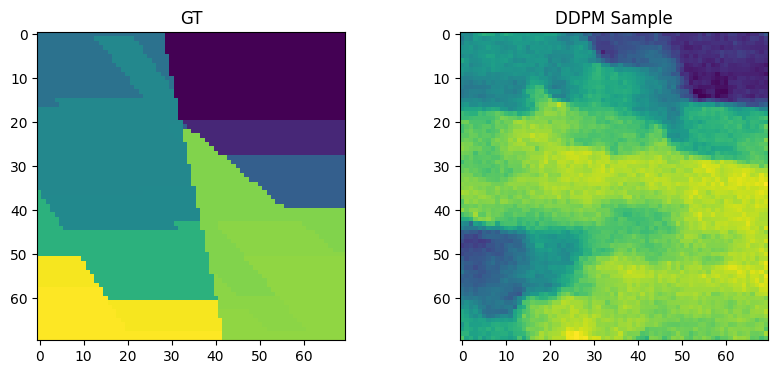

In [89]:

# Cell 6
model = SimpleUNet().to(device)
model.load_state_dict(torch.load("best_ddpm_model.pt", map_location=device))
model.eval()

# 1サンプル取り出し
wave, gt_vel = val_ds[0]
wave = wave.unsqueeze(0).to(device)
cond = wave.view(1,-1)
gt   = gt_vel.unsqueeze(0).to(device)

# スケジュール再用意
T = 1000
betas = linear_beta_schedule(T).to(device)
alphas = 1 - betas
acum, one_m_acum = get_alphas(betas)

@torch.no_grad()
def p_sample(x, t, cond):
    eps_p = model(x, t, cond)
    beta_t = betas[t]
    a_t    = alphas[t]
    ab_t   = acum[t]**2      # ᾱ_t
    ab_prev= torch.cat([torch.tensor([1.],device=t.device), acum[:-1]**2])[t]
    coef = beta_t / (1-ab_t).sqrt()
    mean = (x - coef.view(-1,1,1,1)*eps_p) / a_t.sqrt().view(-1,1,1,1)
    var  = beta_t * (1-ab_prev)/(1-ab_t)
    if (t>0).any():
        return mean + var.sqrt().view(-1,1,1,1)*torch.randn_like(x)
    else:
        return mean

# 全ステップ逆拡散
x = torch.randn_like(gt)
for ti in trange(T-1, -1, -1):
    t = torch.tensor([ti], device=device)
    x = p_sample(x, t, cond)

# 可視化
pred = x.clamp(0,1).squeeze().cpu().numpy()*4500
gt   = gt.squeeze().cpu().numpy()*4500
fig,axs=plt.subplots(1,2,figsize=(10,4))
axs[0].imshow(gt,   cmap="viridis"); axs[0].set_title("GT")
axs[1].imshow(pred,cmap="viridis"); axs[1].set_title("DDPM Sample")
plt.show()
